In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from dataclasses import dataclass

In [ ]:
!pip install celluloid

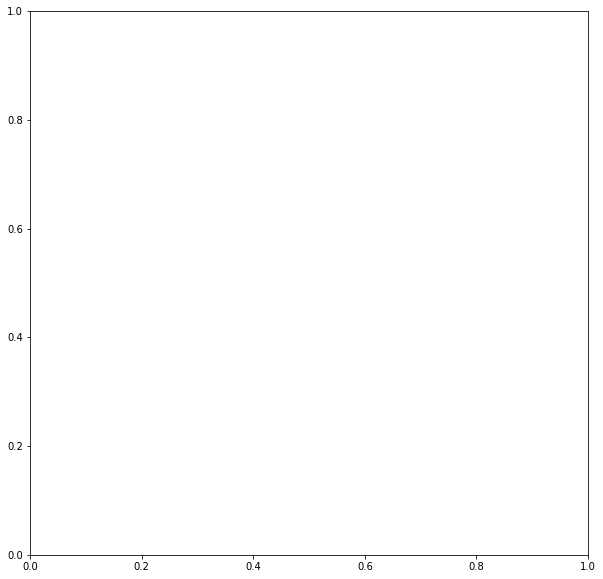

In [ ]:
from celluloid import Camera
fig, ax = plt.subplots(figsize=(10,10))
camera = Camera(fig)


In [ ]:
NUMP = 20
NUMS = NUMP + 1
R = 0.816
KS  = 1800.0
KD = 65.0
MASS = 1.0
DT = 0.001
FINAL_PRESSURE = 85.0
Pressure = 0.0
iters = 10000

WALL_NUMS = 50
WALL_HEIGHT = 10.0
v0x, v0y = -3.65, -3.65

In [ ]:
@dataclass
class point:
    x : float
    y : float
    vx : float
    vy : float
    fx : float
    fy : float
@dataclass
class spring:
    i : int
    j : int
    length : float
    nx : float
    ny : float

In [ ]:
points = [None] * NUMP
springs = [None] * NUMS
wall = [None] * WALL_NUMS

In [ ]:
def grad_potential(r):
    e = 10**(-10)
    a = 1
    return 24 * a**6 * e * (-2 * a**6 + r**6) / r**13

In [ ]:
def CreateWall():
    h = WALL_HEIGHT / WALL_NUMS
    for i in range(WALL_NUMS):
        wall[i] = point(0, i * h, 0, 0, 0, 0)

In [ ]:
def AddSpring(pi, i, j):
    springs[pi] = spring(0, 0, 0, 0, 0)
    springs[pi].i = i;
    springs[pi].j = j;
    springs[pi].length = np.sqrt( 
       (points[ i ].x - points[ j ].x) * 
       (points[ i ].x - points[ j ].x) + 
       (points[ i ].y - points[ j ].y) * 
       (points[ i ].y - points[ j ].y) 
      );

In [ ]:
def CreateBall(C):
    for i in range(NUMP):
        points[i] = point(C.x + R * np.cos(i * 2 * np.pi / NUMP), C.y + R * np.sin(i * 2 * np.pi / NUMP), v0x, v0y, 0, 0)
    for i in range(NUMP - 1):
        AddSpring(i, i, i + 1)
    AddSpring(NUMP - 1, NUMP - 1, 0)     

In [ ]:
def DrawBall(iter):
    x_w = np.array([wall[i].x  for i in range(WALL_NUMS)])
    y_w = np.array([wall[i].y  for i in range(WALL_NUMS)])
    x = [points[i].x for i in range(NUMP)]
    x.append(points[0].x)
    x = np.array(x)
    y = [points[i].y for i in range(NUMP)]
    y.append(points[0].y)
    y = np.array(y)
    #ax.plot(x_w , y_w, "-r")
    ax.plot(x, y, "-*b")
    camera.snap()
    #plt.savefig(path + 'mds_iter_' + str(iter) + '.png')
    #plt.show()

In [ ]:
def AccumulateForces():
    for i in range(NUMP):
        points[i].fx = 0.0
        points[i].fy = 0.0
    # spring forces
    for i in range(NUMP):
        x1 = points[springs[i].i].x
        y1 = points[springs[i].i].y
        x2 = points[springs[i].j].x
        y2 = points[springs[i].j].y
        r12d = np.sqrt((x1 - x2)**2  +  (y1 - y2)**2)
        
        if r12d != 0:
            vx12 = points[springs[i].i].vx - points[springs[i].j].vx
            vy12 = points[springs[i].i].vy - points[springs[i].j].vy

            f = (r12d -  springs[i].length) * KS + (vx12 * (x1 - x2) + vy12 * (y1 - y2)) * KD / r12d

            Fx = ((x1 - x2) / r12d ) * f
            Fy = ((y1 - y2) / r12d ) * f

            points[springs[i].i].fx -= Fx
            points[springs[i].i].fy -= Fy

            points[springs[i].j].fx += Fx
            points[springs[i].j].fy += Fy
        springs[i].nx =  -(y1 - y2) / r12d
        springs[i].ny =  (x1 - x2) / r12d
    # update volume
    volume  = 0.0
    for i in range(NUMP - 1):
        x1 = points[springs[i].i].x
        y1 = points[springs[i].i].y
        x2 = points[springs[i].j].x
        y2 = points[springs[i].j].y
        r12d = np.sqrt ( (x1 - x2)**2  +  (y1 - y2)**2)	
													
        volume += 0.5 * np.abs(x1 - x2) * np.abs(springs[i].nx) * (r12d)
    # pressure
    for i in range(NUMP):
        x1 = points[springs[i].i].x
        y1 = points[springs[i].i].y
        x2 = points[springs[i].j].x
        y2 = points[springs[i].j].y
        r12d = np.sqrt ( (x1 - x2)**2  +  (y1 - y2)**2)

        pressurev = r12d * Pressure * (1.0 / volume)
        points[ springs[i].i ].fx += springs[ i ].nx * pressurev
        points[ springs[i].i ].fy += springs[ i ].ny * pressurev
        points[ springs[i].j ].fx += springs[ i ].nx * pressurev
        points[ springs[i].j ].fy += springs[ i ].ny * pressurev
    #wall
    for i in range(NUMP):
        x = points[i].x
        y = points[i].y
        f_w_x = 0.0
        f_w_y = 0.0
        r = np.abs(x)
        gradLD = grad_potential(r)
        #for j in range(WALL_NUMS):
        #    rx = wall[j].x - x
        #    ry = wall[j].y - y
        #    r = np.sqrt(rx**2 + ry**2)
        #    rx /= r
        #    ry /= r
        #    gradLD += grad_potential(r)
        #    f_w_x +=  rx
        #    f_w_y +=  ry

        points[i].fx += -gradLD
        #points[i].fy += gradLD * f_w_y

In [ ]:
def integrate():
    vt_2_x = []
    vt_2_y = []
    for i in range(NUMP):
        points[i].x += points[i].vx * DT + 0.5 * (points[i].fx / MASS )* DT * DT
        vt_2_x.append(points[i].vx + 0.5 * (points[i].fx / MASS )* DT)
        points[i].y += points[i].vy * DT + 0.5 * (points[i].fy / MASS )* DT * DT
        vt_2_y.append(points[i].vy + 0.5 * (points[i].fy / MASS )* DT)
    AccumulateForces()
    for i in range(NUMP):
        points[i].vx = vt_2_x[i] +  0.5 * (points[i].fx / MASS )* DT
        points[i].vy = vt_2_y[i] +  0.5 * (points[i].fy / MASS )* DT

In [ ]:
c = point(6.0, 1.0, 0, 0, 0, 0)
CreateBall(c)
CreateWall()
AccumulateForces()
for i in range(iters):
    integrate()
    if Pressure < FINAL_PRESSURE:
		     Pressure += FINAL_PRESSURE / 50.0
    if i % 50 == 0: 	
        DrawBall(i)
anim = camera.animate()

from IPython.display import HTML
HTML(anim.to_html5_video())

